<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-gurobi-with-guesses-about-AR" data-toc-modified-id="Use-gurobi-with-guesses-about-AR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Use gurobi with guesses about AR</a></span><ul class="toc-item"><li><span><a href="#Helper-classes-and-functions" data-toc-modified-id="Helper-classes-and-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Helper classes and functions</a></span></li></ul></li><li><span><a href="#Classical-times" data-toc-modified-id="Classical-times-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classical times</a></span><ul class="toc-item"><li><span><a href="#Optimal-time" data-toc-modified-id="Optimal-time-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Optimal time</a></span></li><li><span><a href="#Match-time,-new" data-toc-modified-id="Match-time,-new-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Match time, new</a></span></li></ul></li><li><span><a href="#Gurobi-modeling" data-toc-modified-id="Gurobi-modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gurobi modeling</a></span></li><li><span><a href="#Gurobi-upper-and-lower-bounds-for-AR" data-toc-modified-id="Gurobi-upper-and-lower-bounds-for-AR-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gurobi upper and lower bounds for AR</a></span><ul class="toc-item"><li><span><a href="#Gurobi-activate" data-toc-modified-id="Gurobi-activate-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Gurobi activate</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

from cartesian_explorer import Explorer
import cartesian_explorer as caex

import qtensor
import socket

In [2]:
cache = caex.caches.JobLibCache("../caex_cache/energy_eff")
if socket.gethostname().startswith('skylake'):
    print('Using ray parallel for caex')
    parallel = caex.parallels.Ray(processes=55)
else:
    parallel = None
    parallel = caex.parallels.Ray(processes=2)
ex = Explorer(cache=cache, parallel=parallel)

2021-06-24 07:57:25,533	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


## Use gurobi with guesses about AR




* $UB$ - upper bound on maxcut cost
* $LB$ - lower bound 
* $C$ - optimal cost
$UB>C$


$AR = \frac{LB}{C} > \frac{LB}{UB}$

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import miplog_helper, scale_helper

In [ ]:
import xarray as xar

### Helper classes and functions

In [5]:

from datetime import datetime, timedelta
from functools import wraps

class throttle():
    """ Decorator class that limits number of calls for function"""
    def __init__(self, per_sec=20):
        self.period = timedelta(microseconds=1000000/per_sec)
        self.t0 = datetime.min

    def __call__(self, fn):
        @wraps(fn)
        def wrapper(*args, **kwargs):
            t1 = datetime.now()
            dt = t1 - self.t0
            secs2wait = (self.period - dt).total_seconds()
            if secs2wait > 0:
                return 

            self.t0 = datetime.now()
            return fn(*args, **kwargs)

        return wrapper

In [6]:
import networkx as nx
from typing import Tuple
import gurobipy as gb
import time

def maxcut_bounds_history(G: nx.Graph,
                          max_time=10*60,
                          max_cost=None,
                          threads=None,
                          timedelta=3,
                          max_ar=1.0,
                          verbose=True,
                          callback=None
                         ) -> Tuple[list, list]:
    p = gb.Model()
    p.setParam('TimeLimit', max_time)
    if max_cost is not None:
        p.setParam('BestObjStop', max_cost)
    if threads is not None:
        p.setParam('Threads', threads)
    if verbose is False:
        p.setParam('OutputFlag', 0)
        
    vdict = {}
    for n in G.nodes:
        vdict[n] = p.addVar(name='v_'+str(n), vtype=gb.GRB.BINARY)
    scaled_v = {v:(2*x - 1) for v, x in vdict.items()}
    C_i = [vdict[i] + vdict[j] - 2*vdict[i]*vdict[j] for i, j in G.edges]
    
    p.setObjective(sum(C_i), gb.GRB.MAXIMIZE)
    
    startop = time.time()
    upper = []
    lower = []
    def clb(model, where):
        # See here https://www.gurobi.com/documentation/9.1/refman/cb_codes.html
        return None
        
    miplog = []
    start = 0

    @throttle(per_sec=1)
    def on_update(model, where, cost, bound):
        nonlocal start
        if start == 0:
            start = time.time()
        dt = time.time()-start
        miplog.append([dt, bound, cost])
        print(f'[{dt}]', 'MIP', 'cost=', cost, 'bound=', bound)

    def clb(model, where):
        # See here https://www.gurobi.com/documentation/9.1/refman/cb_codes.html
        if where == gb.CallbackClass.MIP:
            cst = model.cbGet(gb.CallbackClass.MIP_OBJBST)
            bnd = model.cbGet(gb.CallbackClass.MIP_OBJBND)
            on_update(model, where, cst, bnd)
        if where == gb.CallbackClass.MIPSOL:
            cst = model.cbGet(gb.CallbackClass.MIPSOL_OBJBST)
            bnd = model.cbGet(gb.CallbackClass.MIPSOL_OBJBND)
            on_update(model, where, cst, bnd)
        
    if callback is None:
        callback = clb
        
    p.optimize(callback=callback)
    miplog.append(
        [time.time()-startop, p.ObjBound, p.ObjVal]
    )
        
    return miplog



Set gurobi thread count to 1, so it's more meaningful to compare between different machines and more correct when doing parallel calculations

In [7]:
GUROBI_THREADS = 1 #set to 0 to use all available

## Classical times

In [67]:
@ex.provider
def graph(N, seed=10):
    return qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=3)

@ex.add_function(provides=('classical_time_gurobi', 'opt_cost'), requires=('graph', ))
def classical_time_gurobi(graph):
    start = time.time()
    c, sol = qtensor.tools.maxcut.gurobi_maxcut(graph, max_time=15*60, threads=GUROBI_THREADS)
    return time.time() - start, c
    
@ex.provider
def gurobi_hist(graph):
    miplog = maxcut_bounds_history(graph, max_time=600)
    dh = miplog_helper.MiplogData(miplog)
    diffs = dh.get_diff_data()
    start = dh.get_starting_point()
    return start, diffs

@ex.provider
def classical_time_gw(graph):
    start = time.time()
    c = qtensor.tools.maxcut.goemans_williamson.gw_cost(graph)
    return time.time() - start
    

In [64]:
@ex.provider
def approx_ratio(p):
    try:
        AR = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val']
        if AR>0:
            return AR
        else:
            raise KeyError
    except KeyError:
        AR = 1 - (0.3-np.log2(p)*0.05)
    return AR

### Optimal time

In [ ]:
max_N = 3000
opt_max_N = 520
seeds = [10, 11, 12, 13, 14]

In [ ]:
x_ext = np.array(range(10, max_N, 36))
x_opt = np.array(range(10, opt_max_N, 16))

opt_time = ex.map_variable(('classical_time_gurobi')
                           , N=x_opt
                           , seed=seeds
                 )


In [ ]:
opt = xar.DataArray(opt_time, dims=('N', 'seeds'), coords=(x_opt, seeds))

In [ ]:
# check the data
plt.plot(x_opt, np.mean(opt_time, -1))

In [ ]:
import  scale_helper
x = scale_helper.generate_x_log(1, 300, 20)
plt.plot(x, x**4, '*-')


### Match time, new

In [65]:
match_ext = np.concatenate([
    np.linspace(30, 100, 2),
    np.linspace(150, 1000, 2),
    #np.linspace(1500, 10000, 6),
])
match_ext = [int(x) for x in match_ext]
print(match_ext)

[30, 100, 150, 1000]


In [68]:
seeds = range(10, 13)
gurobi_bytes = ex.map_variable(('gurobi_hist')
                             , N=match_ext
                             , seed=seeds
                 )

2021-06-24 11:51:19,908	ERROR worker.py:980 -- Possible unhandled error from worker: ray::apply_kwargs() (pid=17886, ip=172.21.180.68)
  File "python/ray/_raylet.pyx", line 463, in ray._raylet.execute_task
  File "/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/parallels.py", line 21, in apply_kwargs
    return func(**kwargs)
  File "/home/plate/ideal-projects/cartesian-explorer/cartesian_explorer/Explorer.py", line 228, in get_variables
    retval = f(**call_kwd)
  File "/usr/local/lib/python3.8/dist-packages/joblib/memory.py", line 591, in __call__
    return self._cached_call(args, kwargs)[0]
  File "/usr/local/lib/python3.8/dist-packages/joblib/memory.py", line 534, in _cached_call
    out, metadata = self.call(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/memory.py", line 761, in call
    output = self.func(*args, **kwargs)
  File "<ipython-input-62-0f6a007061b7>", line 14, in gurobi_hist
NameError: name 'dh' is not defined
2021-06-24 11:5

KeyboardInterrupt: 

In [11]:
gurobi_bytes

array([[b'\x00\x00\x02\x00\x02p\x00\x02q',
        b'\x00\x00\x02\x00\x02\x80\x00\x02\x81',
        b'\x00\x00\x02\x00\x02\x90\x00\x02\x91'],
       [b'\x00\x00\x02\x00\x03\xc0\x00\x03\xc1',
        b'\x00\x00\x02\x00\x03\xb0\x00\x03\xb1',
        b'\x00\x00\x02\x00\x03\xb0\x00\x03\xb1'],
       [b'\x00\x00\x02\x00\x04\xe0\x00\x04\xe1',
        b'\x00\x00\x02\x00\x04\xe0\x00\x04\xe1',
        b'\x00\x00\x02\x00\x04\xe0\x00\x04\xe1'],
       [b'\x00\x00\x12\x00\x06P\x00\x06\x01\x00\x80\x10\x00@\x11',
        b'\x00\x00\x12\x00\x060\x00\x06!\x00\x00\x00',
        b'\x00\x00\x02\x00\x06 \x00\x06!'],
       [((1.0781638622283936, 120.0, 113.0), [(1, 1.065075397491455, 1.0), (2, 1, 2.999999999999986), (1, 0.7713742256164551, 3.0), (2, 1, 1.4210854715202004e-14)]),
        b'\x00\x00\x12\x00\x07\x90\x00\x07q\x00@\x10',
        b'\x00\x00\x12\x00\x07\x80\x00\x07Q\x00\x80\x10'],
       [b'\x00\x00\x12\x00\x08\xf0\x00\x08Q\x01@\x10\x00\xc0\x11',
        b'\x00\x00\x12\x00\x08\xb0\x00\x08\x91\x0

(0.8, 1.2)

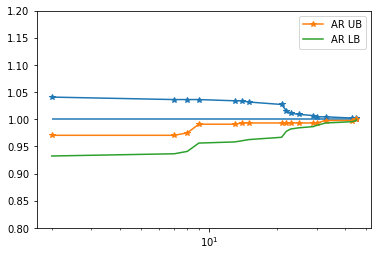

In [61]:
dat = gurobi_bytes[7][2]

mh = to_mh(dat)
mh.plot()
plt.ylim(0.8, 1.2 )

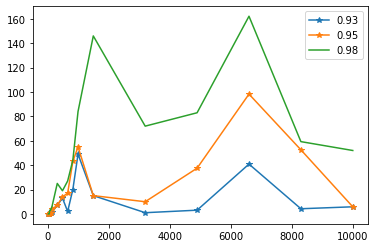

In [52]:
line = [get_time_for_AR_upper(to_mh(x).miplog, 0.93)[0] for x in gurobi_bytes[:, 0]]
plt.plot(match_ext, line, '*-', label='0.93')
plt.legend()
line = [get_time_for_AR_upper(to_mh(x).miplog, 0.95)[0] for x in gurobi_bytes[:, 0]]
plt.plot(match_ext, line, '*-', label='0.95')

line = [get_time_for_AR_upper(to_mh(x).miplog, 0.98)[0] for x in gurobi_bytes[:, 0]]
plt.plot(match_ext, line, label='0.98')
plt.legend()

## Gurobi modeling

In [ ]:
import tqdm.auto as tqdm

import time

In [ ]:
SEEDS = range(1, 2)

In [ ]:
for seed in SEEDS:
    miplog3 = maxcut_bounds_history(nx.random_regular_graph(3, 390, seed=seed), max_time=200, )

In [ ]:
dh = miplog_helper.MiplogData(miplog3)
byt = dh.get_bytes()
dh2 = miplog_helper.MiplogData.from_bytes(byt)
miplog4 = dh2.miplog
miplog4

In [ ]:
mipd = np.array(miplog4).T

start = 2
opt = mipd[2][-1]
ix = np.argmin(np.abs(30-mipd[0]))
print('ix', ix, mipd[0][ix])
cost_lb = mipd[2][ix]
plt.plot(mipd[0][start:], mipd[1][start:]/opt, '*-')
plt.plot(mipd[0][start:], mipd[2][start:]/(opt), '*-', label='AR')
plt.plot(mipd[0][start:], mipd[2][start:]/cost_lb, '*-', label='AR UB')
plt.plot(mipd[0][start:], mipd[2][start:]/mipd[1][start:], '-', label='AR LB')
plt.legend()
plt.xscale('log')
plt.hlines(1, min(mipd[0][start:]), max(mipd[0]))

In [31]:
def get_time_for_AR_lower(miplog, AR):
    """ 
    Args:
        miplog (np.array): :,3 shaped array with times, upper bound cost and lower bound cost
        AR (float): which AR bound to look for
    Returns:
        time, AR
    """
    times, bounds, costs = np.array(miplog)[1:].T
    AR_bound = costs/bounds
    # get the index at which AR bound is higher than requested
    ix = np.where((AR_bound-AR)>0)[0]
    if len(ix)==0: return None, None
    else: ix = min(ix)
    return times[ix], AR_bound[ix]
    

In [32]:
get_time_for_AR_lower(miplog, 0.9)

NameError: name 'miplog' is not defined

In [33]:
def get_time_for_AR_upper(miplog, AR):
    """ 
    Args:
        miplog (np.array): :,3 shaped array with times, upper bound cost and lower bound cost
        AR (float): which AR bound to look for
    Returns:
        time, AR
    """
    times, bounds, costs = np.array(miplog)[1:].T
    AR_bound = costs/costs[-1]
    # get the index at which AR bound is higher than requested
    ix = np.where((AR_bound-AR)>=0)[0]
    if len(ix)==0: return None, None
    else: ix = min(ix)
    return times[ix], AR_bound[ix]
    

In [ ]:
get_time_for_AR_upper(miplog3, 0.999), get_time_for_AR_lower(miplog3, 0.996)

In [ ]:
get_time_for_AR_upper(miplog4, 0.999), get_time_for_AR_lower(miplog4, 0.996)

In [ ]:
times = [(get_time_for_AR_upper(miplog, x)[0],
         get_time_for_AR_lower(miplog, x)[0]) for x in np.linspace(0.85, 1, 20)]

In [ ]:
_t = np.array(times).T
plt.plot(np.linspace(0.85, 1, 20), _t[0], label='upper')
plt.plot(np.linspace(0.85, 1, 20), _t[1], label='lower')
plt.legend()
plt.ylabel('Time to achieve')
plt.xlabel('AR')
plt.yscale('log')

In [ ]:
plt.hist(np.log(dt), bins=50)

In [ ]:
plt.plot(mipd[0])

In [ ]:
i

In [ ]:
for upper, lower in zip(updata, ldata):
    plt.plot(upper, label='upper', alpha=0.3, color='r')
    plt.plot(lower, label='lower', alpha=0.3, color='b')
    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')

In [ ]:
for upper, lower in zip(updata, ldata):
    upper = np.array(upper)
    lower = np.array(lower)
    x = range(1, len(lower)+1)
    #plt.plot(upper/upper.min(), label='upper', alpha=0.3, color='r')
    plt.plot(x, lower/lower.max(), label='lower', alpha=0.3, color='b')
    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')

In [ ]:
for upper, lower in zip(updata, ldata):
    upper = np.array(upper)
    lower = np.array(lower)
    x = range(0, len(lower))
    #plt.plot(upper/upper.min(), label='upper', alpha=0.3, color='r')
    plt.plot(x, lower/lower.max(), label='lower', alpha=0.3, color='b')
plt.xscale('symlog')    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')
plt.grid()

## Gurobi upper and lower bounds for AR

$$$
\foreach \delta>0 AR(t+\delta)>AR(t)
$$$

### Gurobi activate

In [ ]:
import socket

if socket.gethostname() == 'DESKTOP-1OG5J92':
    gurobi_lic = '/home/plate/git-built/gurobi/'
    print('getting license')
    grbkey = 'd3f381ce-d331-11eb-89be-0242ac120002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey
    
elif socket.gethostname().startswith('skylake'):
    gurobi_lic = '/home/danlkv/git-build/gurobi/'
    print('getting license')
    grbkey = '3ef58f36-d29b-11eb-871f-0242ac120002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey

In [ ]:
socket.gethostname()

In [ ]:
qtensor.tools.maxcut.gurobi_maxcut(nx.random_regular_graph(3, 12))